# 07f scATAC LSK Signac ChromVar part2

ChromVar on LSK cells

used this docker image

docker run 
--rm 
-d 
--name signac 
-p 8880:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
signac:0.2.5

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.3”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

In [2]:
combo <- readRDS("./sc_objects/scATAC_combo_processed_macs2.rds")

In [3]:
library(BSgenome.Mmusculus.UCSC.mm10)

Loading required package: BSgenome
Loading required package: Biostrings
Loading required package: XVector

Attaching package: 'XVector'

The following object is masked from 'package:purrr':

    compact


Attaching package: 'Biostrings'

The following object is masked from 'package:base':

    strsplit

Loading required package: rtracklayer


In [4]:
combo

An object of class Seurat 
265122 features across 8959 samples within 2 assays 
Active assay: peaks (243581 features, 232535 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

In [5]:
# Get a list of motif position frequency matrices from the JASPAR database
DefaultAssay(combo) <- 'peaks'
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

# Scan the DNA sequence of each peak for the presence of each motif
motif.matrix <- CreateMotifMatrix(
  features = StringToGRanges(rownames(combo), sep = c(":", "-")),
  pwm = pfm,
  genome = 'mm10',
  sep = c(":", "-"),
  use.counts = FALSE
)

# Create a new Mofif object to store the results
motif <- CreateMotifObject(
  data = motif.matrix,
  pwm = pfm
)

# Add the Motif object to the assay
combo[['peaks']] <- AddMotifObject(
  object = combo[['peaks']],
  motif.object = motif
)

# calculates sequence statistics for motif enrichment

combo <- RegionStats(
  object = combo,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  sep = c(":", "-")
)

In [6]:
combo <- RunChromVAR(
  object = combo,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

DefaultAssay(combo) <- 'chromvar'

Computing GC bias per region
Selecting background regions
Computing motif deviations from background
Constructing chromVAR assay


In [7]:
# calculate motif enrichment for each cluster

DefaultAssay(combo) <- 'chromvar'
combo.markers_cv <- FindAllMarkers(combo, 
                                   only.pos = FALSE,
                                   min.pct = 0,
                                   logfc.threshold = 0
                                   )

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7


In [8]:
motifnames <- GetMotifData(object = combo, assay = 'peaks', slot = 'motif.names')
motifnames <- t(as.data.frame((motifnames)))
colnames(motifnames) <- c("gene_name")
motifnames <- data.frame(gene = row.names(motifnames), motifnames)
combo.markers_cv <- merge(combo.markers_cv, motifnames, by = 'gene')

In [9]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 0))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0009.2,1.473867e-06,0.1272893,0.509,0.463,6.661877e-04,0,T
MA0017.2,1.329599e-05,-0.1922831,0.448,0.492,6.009786e-03,0,NR2F1
MA0027.2,3.385089e-05,-0.1150290,0.459,0.507,1.530060e-02,0,EN1
MA0028.2,1.539011e-10,-0.5481414,0.410,0.473,6.956332e-08,0,ELK1
MA0030.1,1.385321e-09,-0.1988835,0.474,0.525,6.261650e-07,0,FOXF2
MA0031.1,2.941105e-08,-0.2463744,0.480,0.526,1.329379e-05,0,FOXD1
MA0033.2,5.543083e-11,-0.3213932,0.477,0.530,2.505474e-08,0,FOXL1
MA0036.3,1.631639e-97,-6.3491017,0.362,0.591,7.375006e-95,0,GATA2
MA0037.3,2.005918e-94,-4.9002802,0.365,0.587,9.066750e-92,0,GATA3


In [10]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 1))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0014.3,8.730882e-07,0.15934042,0.528,0.473,3.946359e-04,1,PAX5
MA0017.2,2.759384e-40,0.46642544,0.615,0.452,1.247241e-37,1,NR2F1
MA0018.3,1.185443e-05,0.04198378,0.453,0.489,5.358202e-03,1,CREB1
MA0025.1,3.600887e-31,0.40963966,0.604,0.468,1.627601e-28,1,NFIL3
MA0028.2,4.659613e-07,0.20650055,0.500,0.445,2.106145e-04,1,ELK1
MA0032.2,1.388894e-06,-0.20744245,0.455,0.505,6.277802e-04,1,FOXC1
MA0036.3,1.006063e-21,-1.99497712,0.607,0.503,4.547407e-19,1,GATA2
MA0037.3,2.958495e-25,-0.78523819,0.623,0.498,1.337240e-22,1,GATA3
MA0043.2,3.020942e-41,0.38737980,0.605,0.444,1.365466e-38,1,HLF


In [11]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 2))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0025.1,7.761365e-16,-0.3461638,0.412,0.504,3.508137e-13,2,NFIL3
MA0028.2,3.196975e-34,0.1253129,0.589,0.429,1.445032e-31,2,ELK1
MA0030.1,4.176582e-06,-0.1943474,0.452,0.519,1.887815e-03,2,FOXF2
MA0031.1,8.129896e-12,-0.3752070,0.445,0.524,3.674713e-09,2,FOXD1
MA0033.2,1.890035e-22,-0.4814607,0.420,0.531,8.542956e-20,2,FOXL1
MA0036.3,1.140107e-51,-5.8030246,0.394,0.543,5.153282e-49,2,GATA2
MA0037.3,7.368248e-46,-4.4532723,0.386,0.542,3.330448e-43,2,GATA3
MA0039.3,8.697375e-10,0.2329786,0.543,0.472,3.931214e-07,2,KLF4
MA0042.2,1.890035e-22,-0.4814607,0.420,0.531,8.542956e-20,2,FOXI1


In [12]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 3))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0018.3,6.432816e-28,0.33800311,0.608,0.463,2.907633e-25,3,CREB1
MA0024.3,8.669355e-20,-0.31678706,0.384,0.498,3.918548e-17,3,E2F1
MA0027.2,9.835105e-07,-0.21583747,0.452,0.499,4.445468e-04,3,EN1
MA0028.2,2.762008e-09,-0.58580369,0.399,0.463,1.248428e-06,3,ELK1
MA0032.2,8.265939e-08,-0.23234084,0.456,0.503,3.736204e-05,3,FOXC1
MA0039.3,1.753779e-05,0.06193388,0.525,0.476,7.927080e-03,3,KLF4
MA0048.2,1.502967e-18,0.38664678,0.571,0.458,6.793411e-16,3,NHLH1
MA0050.2,8.162988e-73,-4.74799457,0.213,0.408,3.689671e-70,3,IRF1
MA0051.1,1.321837e-61,-1.29610013,0.297,0.483,5.974702e-59,3,IRF2


In [13]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 4))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0009.2,7.134470e-05,-0.1742371,0.438,0.483,3.224780e-02,4,T
MA0017.2,7.376195e-26,-0.4524173,0.351,0.497,3.334040e-23,4,NR2F1
MA0018.3,6.519229e-08,-0.2626586,0.415,0.493,2.946691e-05,4,CREB1
MA0027.2,4.474767e-11,0.1813469,0.567,0.481,2.022595e-08,4,EN1
MA0028.2,8.792475e-38,-0.7977407,0.297,0.477,3.974199e-35,4,ELK1
MA0030.1,6.998511e-23,0.4050357,0.619,0.493,3.163327e-20,4,FOXF2
MA0031.1,1.012791e-42,0.4866834,0.655,0.490,4.577813e-40,4,FOXD1
MA0032.2,6.571836e-08,0.1870265,0.545,0.490,2.970470e-05,4,FOXC1
MA0033.2,9.803400e-55,0.4875368,0.686,0.488,4.431137e-52,4,FOXL1


In [14]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 5))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0014.3,1.367071e-11,0.3307163,0.622,0.476,6.179160e-09,5,PAX5
MA0017.2,7.536816e-22,0.8295120,0.667,0.470,3.406641e-19,5,NR2F1
MA0018.3,7.109493e-06,0.3196965,0.578,0.479,3.213491e-03,5,CREB1
MA0024.3,4.005140e-20,0.5682315,0.669,0.473,1.810323e-17,5,E2F1
MA0028.2,9.328541e-64,1.8875450,0.776,0.439,4.216501e-61,5,ELK1
MA0030.1,6.363483e-10,-0.3833778,0.409,0.513,2.876294e-07,5,FOXF2
MA0031.1,1.826990e-12,-0.4843981,0.380,0.517,8.257994e-10,5,FOXD1
MA0033.2,6.493280e-17,-0.5889419,0.341,0.521,2.934962e-14,5,FOXL1
MA0036.3,3.845572e-54,-1.9257949,0.224,0.533,1.738199e-51,5,GATA2


In [15]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 6))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0028.2,4.956766e-07,0.1797261,0.563,0.449,2.240458e-04,6,ELK1
MA0030.1,1.795473e-07,0.2164667,0.625,0.504,8.115539e-05,6,FOXF2
MA0036.3,1.916103e-168,6.4170359,0.983,0.500,8.660788e-166,6,GATA2
MA0037.3,2.194438e-164,5.2530306,0.992,0.498,9.918858e-162,6,GATA3
MA0043.2,1.890753e-06,-0.7407436,0.353,0.475,8.546204e-04,6,HLF
MA0046.2,5.974539e-07,0.3220578,0.602,0.490,2.700492e-04,6,HNF1A
MA0048.2,4.070527e-21,-0.6634580,0.266,0.482,1.839878e-18,6,NHLH1
MA0050.2,1.357080e-54,-5.2394490,0.081,0.394,6.134000e-52,6,IRF1
MA0051.1,1.803639e-24,-1.4536171,0.277,0.464,8.152450e-22,6,IRF2


In [16]:
(combo.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 7))[1:10,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0009.2,3.999210e-08,-0.4920652,0.332,0.480,1.807643e-05,7,T
MA0017.2,5.488383e-10,-0.6207134,0.290,0.482,2.480749e-07,7,NR2F1
MA0027.2,5.244532e-12,0.5877073,0.699,0.488,2.370529e-09,7,EN1
MA0028.2,1.096181e-20,-0.9504021,0.197,0.459,4.954738e-18,7,ELK1
MA0030.1,5.526200e-31,0.8655772,0.839,0.502,2.497842e-28,7,FOXF2
MA0031.1,1.006202e-42,1.2945472,0.860,0.504,4.548035e-40,7,FOXD1
MA0032.2,3.773775e-18,0.7256904,0.756,0.491,1.705746e-15,7,FOXC1
MA0033.2,6.161390e-51,1.7011624,0.891,0.505,2.784948e-48,7,FOXL1
MA0036.3,1.856043e-49,-2.1794293,0.943,0.510,8.389312e-47,7,GATA2


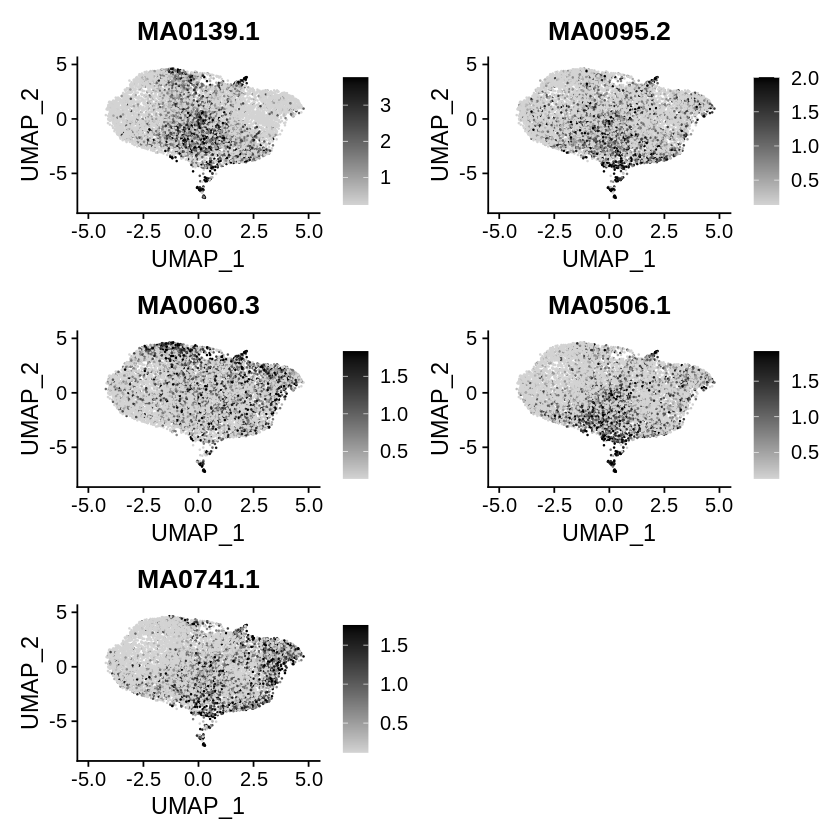

In [17]:
plot = FeaturePlot(
  object = combo,
  features = c(
               'MA0139.1',
                                       'MA0095.2', 
                                       'MA0060.3',
                                        "MA0506.1",
                                          'MA0741.1'
                ),
  cols = c('lightgrey', 'black'),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.08,
  ncol = 2,
)

#plot + coord_fixed(ratio = 0.55)
plot 

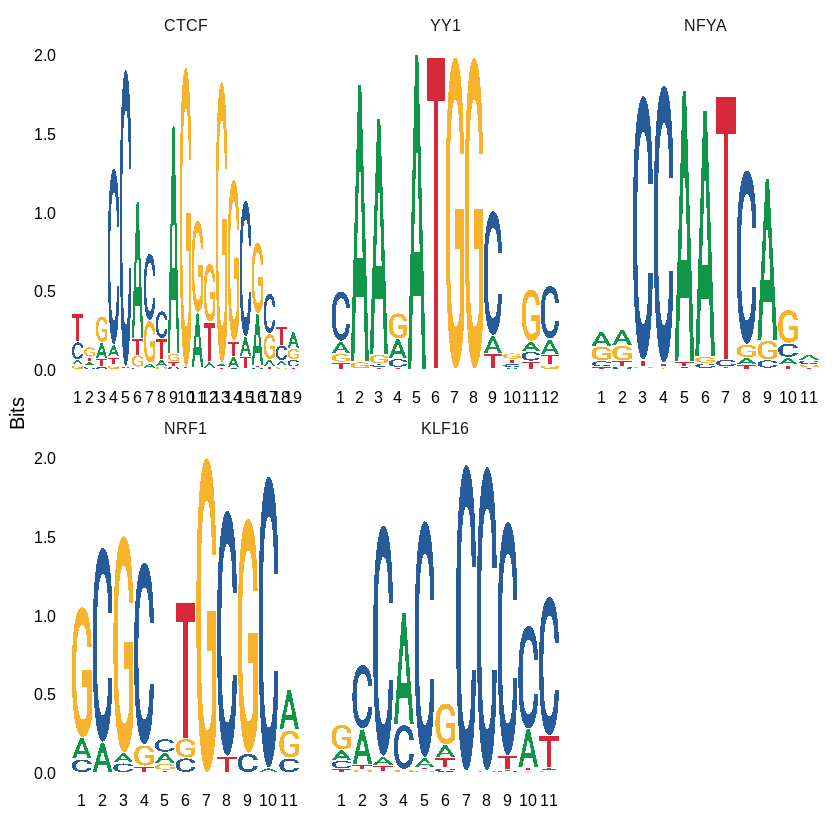

In [18]:
MotifPlot(
  object = combo,
  motifs = c(
              'MA0139.1',
                                       'MA0095.2', 
                                       'MA0060.3',
                                        "MA0506.1",
                                          'MA0741.1'),
  assay = 'peaks'
)

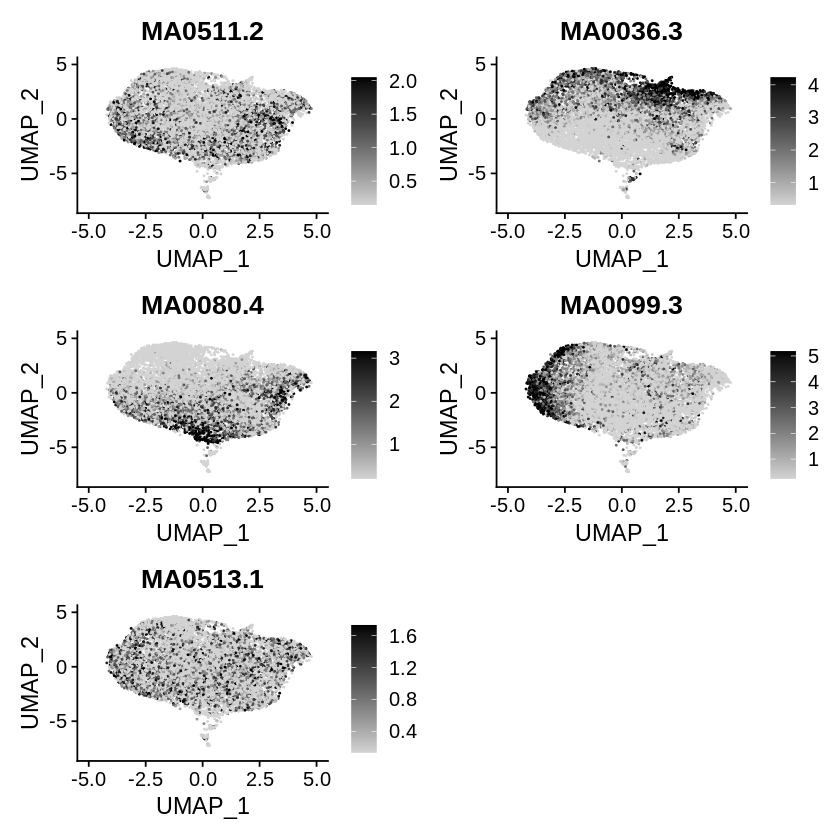

In [19]:
plot = FeaturePlot(
  object = combo,
  features = c(
               'MA0511.2',
               'MA0036.3',
               "MA0080.4",         
               'MA0099.3',
               "MA0513.1"
                ),
  cols = c('lightgrey', 'black'),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.15,
  #ncol = 2,
)

#plot + coord_fixed(ratio = 0.85)
plot

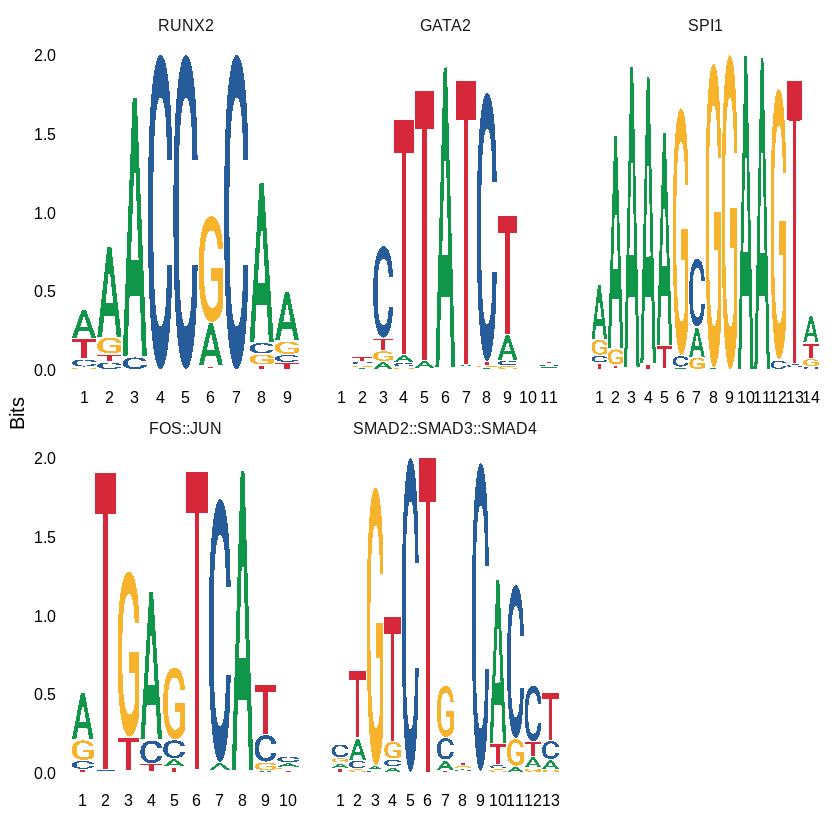

In [20]:
MotifPlot(
  object = combo,
  motifs = c(
              'MA0511.2',
               'MA0036.3',
               "MA0080.4",         
               'MA0099.3',
               "MA0513.1"),
  assay = 'peaks'
)

In [21]:
# write out csvs of motif enrichments

write.csv(combo.markers_cv,'./write/combo_markers_cv_macs2.csv')

In [22]:
# with chromvar

### save MMP object

saveRDS(combo, file = "./sc_objects/scATAC_combo_processed_chromvar_macs2.rds")

In [23]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Mmusculus.UCSC.mm10_1.4.0 BSgenome_1.54.0                   
 [3] rtracklayer_1.46.0                 Biostrings_2.54.0                 
 [5] XVector_0.26.0                     forcats_0.4.0                     
 [7] stringr_1.4.0                      dplyr_1.0.2                       
 